# CRUD в Django

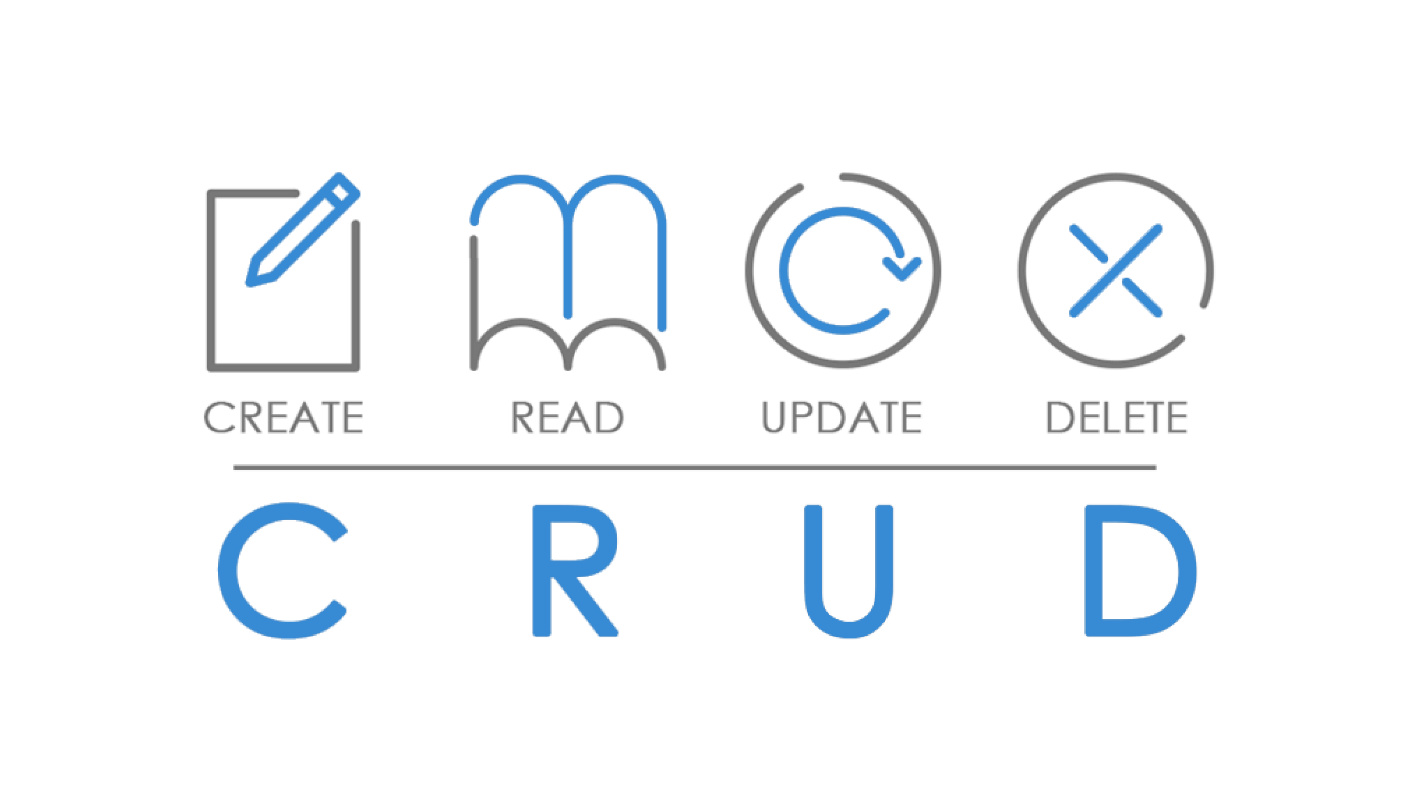

__CRUD__ в веб-разработке — это аббревиатура, обозначающая четыре основные функции, связанные с управлением данными: Создание (__Create__), Чтение (__Read__), Обновление (__Update__) и Удаление (__Delete__). В контексте Django, это концепции, лежащие в основе работы с моделями и базой данных через Django ORM (Object-Relational Mapping)

## 1. Создание (Create)

   В Django данные создаются путем создания экземпляров моделей и сохранения их в базе данных.

### Django ORM

В Django ORM это выглядит следующим образом:

In [ ]:
from tasks.models import Project, Task

project = Project(name="Web Development", description="Web Development Project")
project.save()

Сначала создается экземпляр класса Project с конкретным названием и описанием. Этот объект находится в памяти и не сохраняется в базе данных, но его можно использовать на стадии работы программы. Затем с помощью метода __save()__ этот экземпляр сохрянается в базе данных.

Также можно использовать метод __create()__, который создает и сохраняет объект в одной операции:

In [ ]:
project = Project.objects.create(name="Project2", description="New project")

### Формы и представления для создания объекта

#### FBV

Для создания экземпляра проекта использовалась функция __create_project()__:

In [ ]:
def create_project(request):
    if request.method == 'POST':
        form = ProjectForm(request.POST)
        if form.is_valid():
            form.save()
            return redirect('tasks:projects_list')
    else:
        form = ProjectForm()
    return render(request, 'tasks/project_create.html', {'form': form})

Она использует форму __ProjectForm()__, которая связана с моделью __Project__:

In [ ]:
class ProjectForm(ModelForm):
    class Meta:
        model = Project
        fields = ['name', 'description']

   Если метод запроса — __POST__ (форма отправлена), создается экземпляр __ProjectForm__ с данными из запроса.
После проверки валидности формы вызывается метод __save()__, который создает новый экземпляр __Project__ в базе данных.

Для создания экземпляра задачи использовалась функция __add_task_to_project()__:

In [ ]:
def add_task_to_project(request, project_id):
    project = get_object_or_404(Project, pk=project_id)
    if request.method == 'POST':
        form = TaskForm(request.POST)
        if form.is_valid():
            task = form.save(commit=False)
            task.project = project
            task.save()
            return redirect('tasks:project_detail', project_id=project.id)
    else:
        form = TaskForm()
    return render(request, 'tasks/add_task.html', {'form': form, 'project': project})

Она использует форму __TaskForm()__, которая связана с моделью __Task__:

In [ ]:
class TaskForm(forms.ModelForm):
    class Meta:
        model = Task
        fields = ['name', 'description', 'status', 'assignee']

После отправки формы создается экземпляр __TaskForm__ с данными запроса.
До сохранения формы в базе данных используется __commit=False__, что позволяет добавить проект к задаче (__task.project = project__), а затем сохранить объект в базе данных.

#### CBV

Представления, основанные на классах, поддерживают все CRUD-операции:

Добавим в __views.py__ следующий код:

In [ ]:
from django.views.generic import CreateView
from django.urls import reverse, reverse_lazy

class ProjectCreateView(CreateView):
    model = Project
    form_class = ProjectForm
    template_name = 'tasks/project_create.html'
    success_url = reverse_lazy('tasks:projects_list')

__ProjectCreateView__ — это класс, наследующийся от __CreateView__, встроенного в Django класса для создания объектов.

   * Атрибут __model__: Указывает, какая модель используется для создания нового объекта. Здесь это модель Project.
   * Атрибут __form_class__: Указывает класс формы, который будет использоваться для создания формы на веб-странице. Здесь это __ProjectForm__.
   * Атрибут __template_name__: Путь к шаблону HTML, который будет использоваться для отображения страницы. Здесь это __'tasks/project_create.html'__.
   * Атрибут __success_url__: URL, на который будет перенаправлен пользователь после успешного создания объекта. Используется __reverse_lazy__ для получения URL по имени маршрута.

In [ ]:
class TaskCreateView(CreateView):
    model = Task
    form_class = TaskForm
    template_name = 'tasks/add_task.html'

    def form_valid(self, form):
        form.instance.project = get_object_or_404(Project, pk=self.kwargs['project_id'])
        return super().form_valid(form)

    def get_success_url(self):
        return reverse('tasks:project_detail', kwargs={'project_id': self.kwargs['project_id']})

__TaskCreateView__ тоже наследуется от __CreateView__ и используется для создания задач.

   * Атрибут __model__: Модель __Task__, используемая для создания новых задач.
   * Атрибут __form_class__: Класс формы __TaskForm__ для создания формы задачи.
   * Атрибут __template_name__: Путь к шаблону, который используется для отображения формы создания задачи (__'tasks/add_task.html'__).
   * Метод __form_valid(form)__: 
      * В __TaskCreateView__, этот метод переопределяется для того, чтобы связать создаваемую задачу с определенным проектом.
      * __form.instance__ представляет новый объект __Task__, который будет сохранен.
      * Связь с проектом устанавливается с помощью __form.instance.project = get_object_or_404(Project, pk=self.kwargs['project_id'])__, где __self.kwargs['project_id']__ — это ID проекта, переданный в URL.
   * Метод __get_success_url()__: Метод для определения URL перенаправления после успешного создания задачи.

В __urls.py__ эти представления подключаются следующим образом:

In [ ]:
urlpatterns = [
    # ... другие URL-маршруты ...
    path('project/create/', views.ProjectCreateView.as_view(), name='create_project'),
    path('project/<int:project_id>/add_task/', views.TaskCreateView.as_view(), name='add_task_to_project'),
]

## 2. Чтение (Read)

Чтение данных включает в себя извлечение данных из базы данных.

### Django ORM

В Django ORM это выглядит следующим образом:

Получение всех записей:

In [ ]:
all_projects = Project.objects.all()

Получение определенной записи по ID

In [ ]:
project = Project.objects.get(id=1)

Использование фильтров:

In [ ]:
project_tasks = Task.objects.filter(project=project)

### Представления для чтения и вывода объектов

#### FBV

Для получения списка из всех проектов использовалась функция __projects_list()__: 

In [ ]:
def projects_list(request):
    projects = Project.objects.all()
    return render(request, 'tasks/projects_list.html', {'project_list': projects})

Функция использует __Project.objects.all()__ для получения всех проектов из базы данных и отображает список всех проектов.

Для получения деталей проекта использовалась функция __project_detail()__:

In [ ]:
def project_detail(request, project_id):
    project = get_object_or_404(Project, id=project_id)
    return render(request, 'tasks/project_detail.html', {'project': project})

Функция использует __get_object_or_404(Project, id=project_id)__ для получения проекта по его ID или возвращает 404, если проект не найден, и показывает детали конкретного проекта. 

Для получения деталей конкретной задачи в проекте использовалась функция task_detail:

In [ ]:
def task_detail(request, project_id, task_id):
    task = get_object_or_404(Task, id=task_id, project_id=project_id)
    return render(request, 'tasks/task_detail.html', {'task': task})

Аналогично __project_detail()__, но для отображения деталей задачи.

#### CBV

Для чтения и вывода объектов также используется представления, основанные на классах.

__ListView__ используется для отображения списка объектов модели. Этот класс автоматически обрабатывает многие общие задачи, такие как выборка набора данных из модели и передача этих данных в шаблон.

__Основные Атрибуты и Методы:__

   * __model__: Модель, из которой будут выбираться объекты.
   * __template_name__: Путь к шаблону HTML, который используется для отображения страницы.
   * __context_object_name__: Название переменной контекста, в которой будут доступны объекты в шаблоне. Если не указано, используется __object_list__.
   * __get_queryset()__: Метод для определения списка объектов, который будет отображаться. Можно переопределить для добавления фильтрации или изменения порядка следования объектов.

In [ ]:
class ProjectsListView(ListView):
    model = Project
    template_name = 'tasks/projects_list.html'

__DetailView__ используется для отображения детальной информации об одном объекте модели. Этот класс автоматически обрабатывает задачи, такие как извлечение объекта по его идентификатору из URL.

__Основные Атрибуты и Методы:__

   * __model__: Модель, объект которой будет отображаться.
   * __template_name__: Путь к шаблону HTML, который используется для отображения страницы.
   * __context_object_name__: Название переменной контекста, в которой будет доступен объект в шаблоне. Если не указано, используется __object__.
   * __pk_url_kwarg__: Название переменной из URL, которая используется для поиска объекта по его первичному ключу (__pk__).

In [ ]:
class ProjectDetailView(DetailView):
    model = Project
    pk_url_kwarg = 'project_id'
    template_name = 'tasks/project_detail.html'


class TaskDetailView(DetailView):
    model = Task
    pk_url_kwarg = 'task_id'
    template_name = 'tasks/task_detail.html'

## 3. Обновление (Update)

Обновление данных происходит путем изменения полей объекта и сохранения этих изменений.

### Django ORM

В Django ORM это выглядит следующим образом:

In [ ]:
project = Project.objects.get(id=1)
project.name = 'new_name'
project.save()

Массовое обновление без явного получения объектов:

In [ ]:
Project.objects.filter(description='old_description').update(description='new_description')

### Формы и представления для обновления объекта

#### FBV

В __views.py__ добавим представление для обновления проекта:

In [ ]:
def update_project(request, project_id):
    project = get_object_or_404(Project, pk=project_id)
    if request.method == 'POST':
        form = ProjectForm(request.POST, instance=project)
        if form.is_valid():
            form.save()
            return redirect('tasks:project_detail', project_id=project.id)
    else:
        form = ProjectForm(instance=project)
    return render(request, 'tasks/project_update.html', {'form': form, 'project': project})

Здесь мы используем ту же форму __ProjectForm__, но передаем ей экземпляр существующего проекта. Тем самым поля формы изначально будут заполненны данными экземпляра проекта.

Создадим шаблон __tasks/project_update.html__:

In [ ]:
{% extends 'base/base.html' %}

{% block content %}
<h2>Изменение проекта: {{ project.name }}</h2>
    <form method="post">
        {% csrf_token %}
        {{ form.as_p }}
        <button type="submit">Сохранить</button>
    </form>
{% endblock %}

В views.py добавим представление для обновления задачи:

In [ ]:
def update_task(request, project_id, task_id):
    task = get_object_or_404(Task, pk=task_id)
    if request.method == 'POST':
        form = TaskForm(request.POST, instance=task)
        if form.is_valid():
            form.save()
            return redirect('tasks:task_detail', project_id=project_id, task_id=task.id)
    else:
        form = TaskForm(instance=task)
    return render(request, 'tasks/task_update.html', {'form': form, 'task': task})

Здесь используется та же форма __TaskForm__, но передаем ей экземпляр существующей задачи.

Создадим шаблон __tasks/task_update.html__:

In [ ]:
{% extends 'base/base.html' %}

{% block content %}
<h2>Изменение задачи: {{ task.name }}</h2>
    <form method="post">
        {% csrf_token %}
        {{ form.as_p }}
        <button type="submit">Сохранить</button>
    </form>
{% endblock %}

Добавьте новые маршруты в __urls.py__ для обработки обновления задач и проектов.

In [ ]:
urlpatterns = [
    # ... другие URL-маршруты ...
    path('project/<int:project_id>/update/', views.update_project, name='update_project'),
    path('project/<int:project_id>/task/<int:task_id>/update/', views.update_task, name='update_task'),
]

На шаблоне с детальной информацией о проекте __tasks/project_detail.html__ добавим ссылку на изменение проекта:

In [ ]:
{% extends 'base/base.html' %}

{% block content %}
    <h1>{{ project.name }}</h1>
    <p>{{ project.description }}</p>

    <!-- Ссылка для изменения проекта -->
    <p><a href="{% url 'tasks:update_project' project.id %}">Изменить проект</a></p>

    <p><a href="{% url 'tasks:add_task_to_project' project.id %}">Добавить новую задачу</a></p>


    <h2>Задачи в проекте</h2>
    <ul>
        {% for task in project.tasks.all %}
            <li><a href="{% url 'tasks:task_detail' project.id task.id %}">{{ task.name }}</a> - {{ task.status }}</li>
        {% empty %}
            <li>В этом проекте пока нет задач.</li>
        {% endfor %}
    </ul>
{% endblock %}

На шаблоне с детальной информацией о задаче __tasks/task_detail.html__ добавим ссылку на изменение задачи:

In [ ]:
{% extends 'base/base.html' %}

{% block content %}
    <a href="{% url 'tasks:update_task' project_id=task.project.id task_id=task.id %}">Изменить задачу</a>


    <h1>{{ task.name }}</h1>
    <p>{{ task.description }}</p>
{% endblock %}

Запустим тестовый сервер и перейдем на страницу проекта:

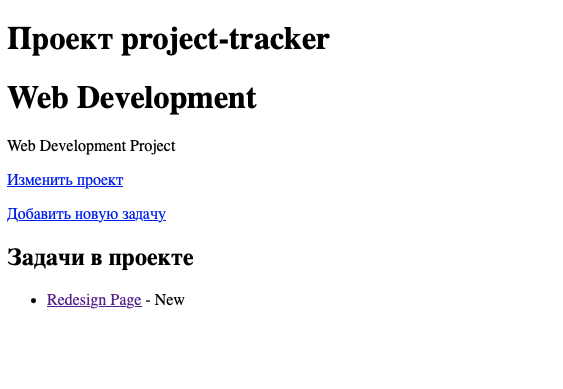

Перейдем к изменению проекта:

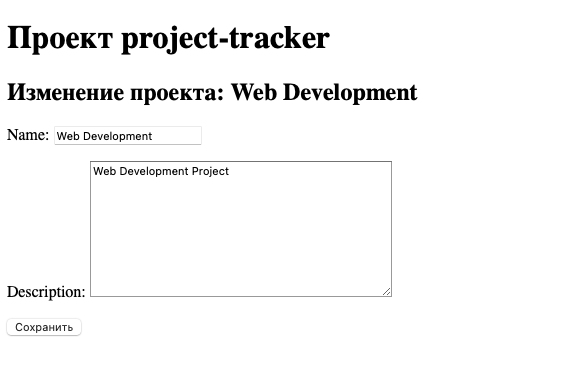

Поля формы заранее заполнены данными проекта, изменив поле и сохранив, изменится значение этого поля в базе данных.

Аналогично с задачами:

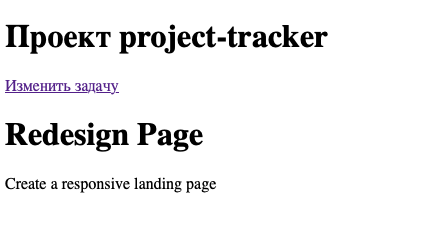

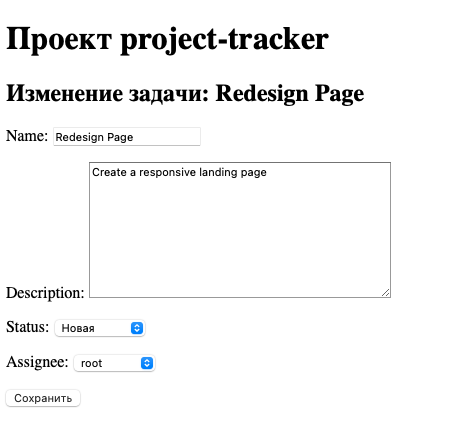

#### CBV

В views.py добавим CBV для обновления проекта и задачи:

In [ ]:
from django.views.generic.edit import UpdateView
from django.urls import reverse_lazy
from .models import Project
from .forms import ProjectForm

class ProjectUpdateView(UpdateView):
    model = Project
    form_class = ProjectForm
    template_name = 'tasks/project_update.html'
    pk_url_kwarg = 'project_id'
    success_url = reverse_lazy('tasks:projects_list')

__ProjectUpdateView__ — это класс, наследующийся от __UpdateView__, встроенного в Django класса для обновления объектов.

   * __model__: Указывает, что мы работаем с моделью __Project__.
   * __form_class__: Ссылка на форму для редактирования проекта.
   * __template_name__: Имя HTML-шаблона, который будет использоваться для отображения страницы.
   * __pk_url_kwarg__: Имя аргумента из URL, который содержит первичный ключ (id) проекта.
   * __success_url__: URL, на который пользователь будет перенаправлен после успешного обновления проекта.

In [ ]:
from .models import Task
from .forms import TaskForm

class TaskUpdateView(UpdateView):
    model = Task
    form_class = TaskForm
    template_name = 'tasks/task_update.html'
    pk_url_kwarg = 'task_id'

    def get_success_url(self):
        return reverse_lazy('tasks:task_detail', kwargs={'project_id': self.object.project.id, 'task_id': self.object.id})

   * __get_success_url__: Метод настраивает URL для перенаправления после обновления задачи, возвращая пользователя к детальному просмотру задачи.

В __urls.py__ эти представления подключаются следующим образом:

In [ ]:
urlpatterns = [
    # ... другие URL-маршруты ...
    path('project/<int:project_id>/update/', views.ProjectUpdateView.as_view(), name='update_project'),
    path('project/<int:project_id>/tasks/<int:task_id>/update/', views.TaskUpdateView.as_view(), name='update_task'),
]

## 4. Удаление (Delete)

Операция удаления в контексте  Django, относится к удалению данных из базы данных. В Django это обычно связано с удалением экземпляров моделей. 

### Django ORM

Удаление отдельных объектов с использованием метода __delete()__:

In [ ]:
task = Task.objects.get(id=1)
task.delete()

Этот код получает задачу с определенным ID из базы данных и удаляет её. Если задача с таким ID не найдена, __get()__ вызовет исключение __Task.DoesNotExist__.

Массовое удаление объектов по фильтру:

In [ ]:
Task.objects.filter(project_id=1).delete()

### Представления для удаления объекта

#### FBV

Добавим в __views.py__ функции для удаления проекта и задачи.

In [ ]:
def delete_project(request, project_id):
    project = get_object_or_404(Project, pk=project_id)
    project.delete()
    return redirect('tasks:projects_list')

def delete_task(request, project_id, task_id):
    task = get_object_or_404(Task, pk=task_id)
    task.delete()
    return redirect('tasks:project_detail', project_id=project_id)

Добавим маршруты в __urls.py__:

In [ ]:
urlpatterns = [
    # ... другие URL-маршруты ...
    path('project/<int:project_id>/delete/', views.delete_project, name='delete_project'),
    path('project/<int:project_id>/tasks/<int:task_id>/delete/', views.delete_task, name='delete_task'),
]

На шаблоне с детальной информацией о проекте __tasks/project_detail.html__ добавим ссылку на удаление проекта:

In [ ]:
{% extends 'base/base.html' %}

{% block content %}
    <h1>{{ project.name }}</h1>
    <p>{{ project.description }}</p>

    <p><a href="{% url 'tasks:update_project' project.id %}">Изменить проект</a></p>

    <p><a href="{% url 'tasks:add_task_to_project' project.id %}">Добавить новую задачу</a></p>

    <!-- Ссылка удаления проекта -->
    <p><a href="{% url 'tasks:delete_project' project.id %}"onclick="return confirm('Вы уверены, что хотите удалить этот проект?');">Удалить проект</a></p>

    <h2>Задачи в проекте</h2>
    <ul>
        {% for task in project.tasks.all %}
            <li><a href="{% url 'tasks:task_detail' project.id task.id %}">{{ task.name }}</a> - {{ task.status }}</li>
        {% empty %}
            <li>В этом проекте пока нет задач.</li>
        {% endfor %}
    </ul>
{% endblock %}

На ссылку добавлен атрибут __onclick__ со встроенным JavaScript, который показывает диалоговое окно подтверждения при нажатии на ссылку. Это помогает предотвратить случайное удаление проекта. Пользователю будет предложено подтвердить действие перед тем, как оно будет выполнено.

На шаблоне с детальной информацией о задаче __tasks/task_detail.html__ добавим ссылку на удаление задачи:

In [ ]:
{% extends 'base/base.html' %}

{% block content %}
    <a href="{% url 'tasks:update_task' project_id=task.project.id task_id=task.id %}">Изменить задачу</a>

    <!-- Кнопка удаления задачи -->
    <p><a href="{% url 'tasks:delete_task' project_id=task.project.id task_id=task.id %}" onclick="return confirm('Вы уверены, что хотите удалить эту задачу?');">Удалить задачу</a></p>

    <h1>{{ task.name }}</h1>
    <p>{{ task.description }}</p>
{% endblock %}

Запустим тестовый сервер и попробуем удалить задачу в проекте:

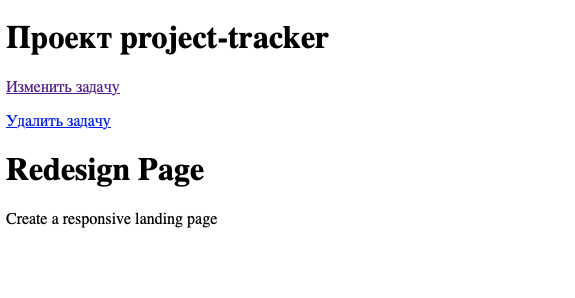

При нажатии на "Удалить задачу" появится поп-ап с подтверждением.

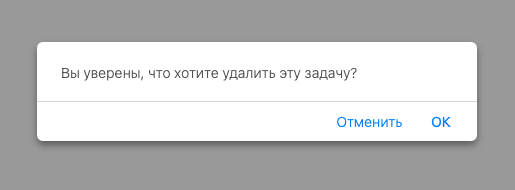

После подтверждения нас отправляет на страницу проекте, где вижно, что задача удалилась.

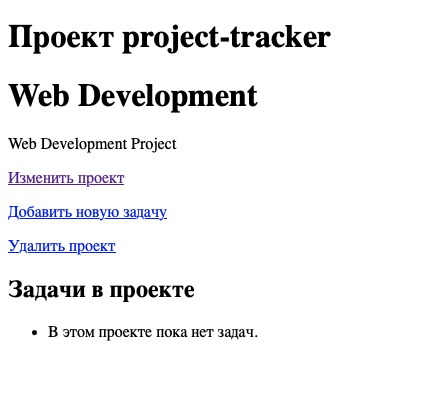

#### CBV

Для создания Class-Based Views (CBV) в Django, которые обрабатывают удаление объектов, можно использовать __DeleteView__.

In [ ]:
from django.views.generic.edit import DeleteView

class ProjectDeleteView(DeleteView):
    model = Project
    pk_url_kwarg = 'project_id'
    success_url = reverse_lazy('tasks:projects_list')
    template_name = 'tasks/project_confirm_delete.html'

   * __template_name__: Шаблон для подтверждения удаления.

In [ ]:
class TaskDeleteView(DeleteView):
    model = Task
    pk_url_kwarg = 'task_id'

    def get_success_url(self):
        return reverse_lazy('tasks:project_detail', kwargs={'project_id': self.object.project.id})

   * __get_success_url__ здесь определяет, куда пользователь будет направлен после удаления задачи.

В __urls.py__ добавьте маршруты для этих новых представлений:

In [ ]:
urlpatterns = [
    # ... другие URL-маршруты ...
    path('project/<int:project_id>/delete/', views.ProjectDeleteView.as_view(), name='delete_project'),
    path('project/<int:project_id>/tasks/<int:task_id>/delete/', views.TaskDeleteView.as_view(), name='delete_task'),
]

Для работы DeleteView требуется создать шаблоны с подтверждением удаления обьектов. Создадим шаблон для подтверждения удаления проекта __tasks/project_confirm_delete.html__:

In [ ]:
{% extends 'base/base.html' %}

{% block content %}
    <h1>Удаление проекта</h1>
    <p>Вы уверены, что хотите удалить проект "{{ project.name }}"?</p>

    <form action="{% url 'tasks:delete_project' project.id %}" method="post">
        {% csrf_token %}
        <input type="submit" value="Удалить">
        <a href="{% url 'tasks:project_detail' project.id %}">Отмена</a>
    </form>
{% endblock %}

Аналогично создадим шаблон для подтверждения удаления задачиа __tasks/task_confirm_delete.html__:

In [ ]:
{% extends 'base/base.html' %}

{% block content %}
    <h1>Удаление задачи</h1>
    <p>Вы уверены, что хотите удалить задачу "{{ task.name }}"?</p>

    <form action="{% url 'tasks:delete_task' task.project.id task.id %}" method="post">
        {% csrf_token %}
        <input type="submit" value="Удалить">
        <a href="{% url 'tasks:task_detail' task.project.id task.id %}">Отмена</a>
    </form>
{% endblock %}

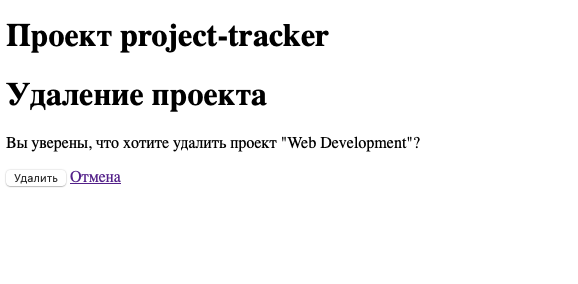

# Домашнее задание

1. Разработайте __FBV__ для каждой CRUD-операции для обеих моделей приложения __quality_control__ (__BugReport__ и __FeatureRequest__). Включите представления для списка объектов, детального просмотра, создания, обновления и удаления. (Некоторые представления уже должны быть созданы, если вы выполняли предыдущие домашние задания)
2. Реализуйте __CBV__, аналогичные FBV, для каждой модели. Используйте __ListView, DetailView, CreateView, UpdateView и DeleteView__. (Некоторые представления уже должны быть созданы, если вы выполняли предыдущие домашние задания)
3. Создайте шаблоны для всех представлений. (Некоторые шаблоны уже должны быть созданы, если вы выполняли предыдущие домашние задания)
4. Настройте URL-маршруты для всех представлений в вашем приложении.